In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [26]:
import cv2
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.learner import cnn_config
from fastai.vision.models.unet import _get_sfs_idxs

from torchvision.models import vgg16_bn

In [4]:
path = Path('/data/Datasets/WhiteBloodCancer/train/')
src = ImageImageList.from_folder(path, recurse=True).random_split_by_pct(0.1, seed=42)

In [5]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: x)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [6]:
data = get_data(64,64)

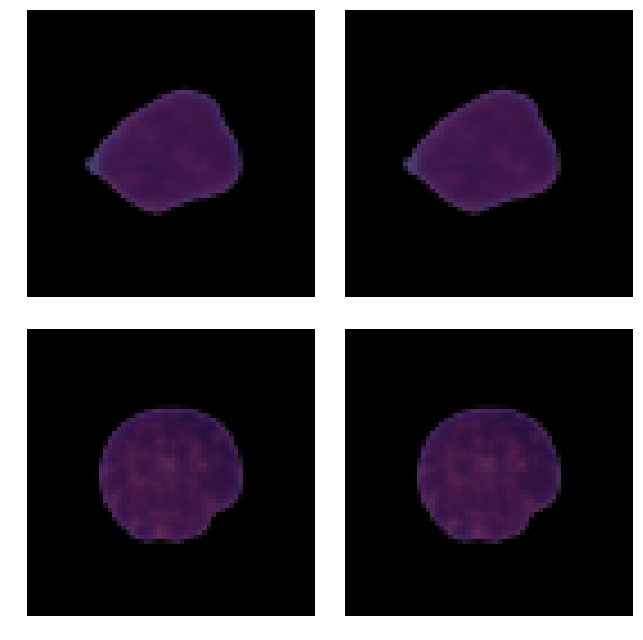

In [19]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

### Loss

In [19]:
t = data.valid_ds[0][1].data
t = torch.stack([t,t])

In [20]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [21]:
gram_matrix(t)

tensor([[[0.0036, 0.0015, 0.0044],
         [0.0015, 0.0007, 0.0019],
         [0.0044, 0.0019, 0.0055]],

        [[0.0036, 0.0015, 0.0044],
         [0.0015, 0.0007, 0.0019],
         [0.0044, 0.0019, 0.0055]]])

In [23]:
base_loss = F.l1_loss

In [27]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [28]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [29]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [30]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

### Autoencoder

In [7]:
class EncoderBlock(nn.Module):
    
    def __init__(self, up_in_c:int, x_in_c:int, bilinear:bool=False, leaky:float=None,
                 self_attention:bool=False, **kwargs):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(up_in_c, x_in_c, 2, stride=2)

        self.conv1 = conv_layer(x_in_c, x_in_c, leaky=leaky, **kwargs)
        self.conv2 = conv_layer(x_in_c, x_in_c, leaky=leaky, self_attention=self_attention, **kwargs)
        self.relu = relu(leaky=leaky)

    def forward(self, up_in:Tensor) -> Tensor:
        up_out = self.up(up_in)

        x = self.relu(up_out)
        return self.conv2(self.conv1(x))

In [13]:
class AutoEncoder(SequentialEx):
    "Create a AutoEncoder from a given architecture."
    def __init__(self, encoder:nn.Module, n_classes:int, middle_nf: int=256, self_attention:bool=False, **kwargs):
        imsize = (256,256)
        sfs_szs = model_sizes(encoder, size=imsize)
        x = dummy_eval(encoder, imsize).detach()

        ni = sfs_szs[-1][1]
        middle_conv = nn.Sequential(conv_layer(ni, middle_nf, **kwargs),
                                    conv_layer(middle_nf, ni, **kwargs)).eval()
        x = middle_conv(x)
        layers = [encoder, batchnorm_2d(ni), nn.ReLU(), middle_conv]

        while x.shape[2] < imsize[0]:
            up_in_c = x.shape[1]
            x_in_c = up_in_c // 2

            encoder_block = EncoderBlock(up_in_c, x_in_c, **kwargs).eval()
            layers.append(encoder_block)
            x = encoder_block(x)

        layers += [conv_layer(x_in_c, n_classes, ks=1, use_activ=False, **kwargs)]
        super().__init__(*layers)

In [14]:
data = get_data(64, 128)
arch = models.resnet18

In [49]:
meta = cnn_config(arch)
body = create_body(arch)
model = to_device(AutoEncoder(body, n_classes=data.c, middle_nf=8), data.device)
learn = Learner(data, model, loss_func=feat_loss, callback_fns=[ShowGraph, LossMetrics])
learn.split(meta['split'])
learn.freeze()
apply_init(model[2], nn.init.kaiming_normal_)

In [42]:
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


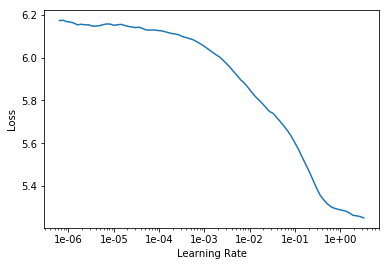

In [43]:
learn.lr_find()
learn.recorder.plot()

In [46]:
learn.summary()

'======================================================================\nLayer (type)         Output Shape         Param #    Trainable \n======================================================================\nConv2d               [64, 64, 64, 64]     9408       False     \n______________________________________________________________________\nBatchNorm2d          [64, 64, 64, 64]     128        True      \n______________________________________________________________________\nReLU                 [64, 64, 64, 64]     0          False     \n______________________________________________________________________\nMaxPool2d            [64, 64, 32, 32]     0          False     \n______________________________________________________________________\nConv2d               [64, 64, 32, 32]     36864      False     \n______________________________________________________________________\nBatchNorm2d          [64, 64, 32, 32]     128        True      \n________________________________________

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,4.210761,4.001457,1.356216,0.260770,0.290385,0.037894,0.908614,1.110873,0.036705
2,2.925549,2.473471,0.461577,0.257783,0.241194,0.035082,0.732885,0.708849,0.036101
3,2.232400,1.895621,0.202274,0.221831,0.207429,0.028905,0.638533,0.562442,0.034208
4,1.348818,0.775865,0.067657,0.084372,0.125047,0.024850,0.145086,0.297130,0.031723
5,0.990989,0.658261,0.060626,0.073886,0.105372,0.022597,0.124141,0.241923,0.029716


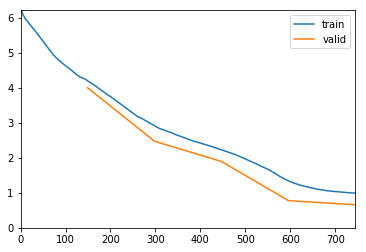

In [50]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.984615,0.775995,0.071821,0.076988,0.114351,0.023447,0.137854,0.321077,0.030457
2,0.913360,0.678003,0.068008,0.068318,0.099480,0.022835,0.118400,0.271046,0.029916
3,0.841357,0.669662,0.047007,0.063178,0.091979,0.021020,0.115337,0.303459,0.027682
4,0.781337,0.509887,0.037345,0.056698,0.080035,0.019994,0.094833,0.194115,0.026868
5,0.755212,0.484851,0.035170,0.053217,0.075554,0.019489,0.089677,0.185495,0.026249


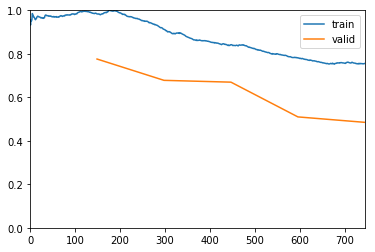

In [51]:
learn.fit_one_cycle(5, 1e-2)

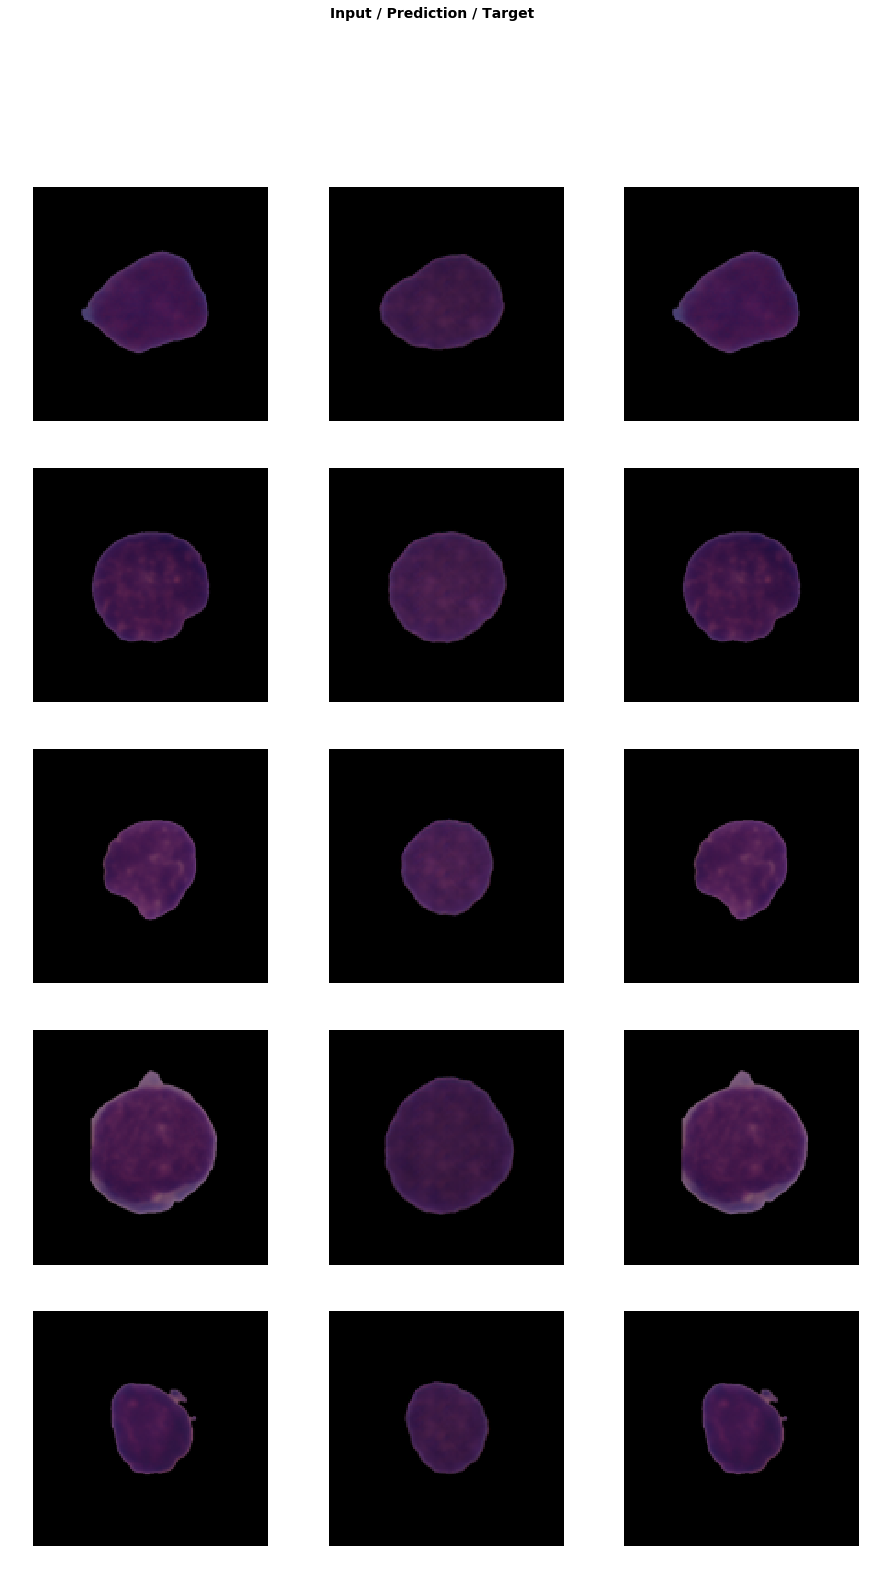

In [52]:
learn.show_results(rows=5, imgsize=5)